In [1]:
import random
import math
import pandas
import matplotlib
import matplotlib.pyplot as plt
import numpy
import scipy

import pmana.utils

#### Get data

This is aggregated data from a brief time window Janaury, 2025, where the lifetime was stable at 20 ms.

In [2]:
PATH_DATA = '/Users/triozzi/Analysis/PurityMonitors'

# read data
StoreData = pandas.read_pickle(f'{PATH_DATA}/JanData_20ms_20250325.pkl') 
# StoreData.head()

short_inner_data = StoreData[['XShort_Inner', 'YShort_Inner']].groupby('XShort_Inner').sum()
short_outer_data = StoreData[['XShort_Outer', 'YShort_Outer']].groupby('XShort_Outer').sum()
long_inner_data = StoreData[['XLong_Inner', 'YLong_Inner']].groupby('XLong_Inner').sum()
long_outer_data = StoreData[['XLong_Outer', 'YLong_Outer']].groupby('XLong_Outer').sum()

#### Get simulation

Simulated the same free electron lifetime with the following energy resolutions, tuned to match the width of the IC peaks in data.

* short-inner: 0.11 MeV
* short-outer: 0.07 MeV
* long-inner: 0.10 MeV
* long-outer: 0.07 MeV

In [3]:
PATH_MC = '/Users/triozzi/Analysis/PurityMonitors/Test'
kwargs = {
  'names': ['i', 'iele', 'timetrig', 'phmax', 'ph'],
  'delimiter' : ' '
}

# read simulation
short_inner = pandas.read_csv(f"{PATH_MC}/inner_anode_short.txt", **kwargs)
short_outer = pandas.read_csv(f"{PATH_MC}/outer_anode_short.txt", **kwargs)
long_inner = pandas.read_csv(f"{PATH_MC}/inner_anode_long.txt", **kwargs)
long_outer = pandas.read_csv(f"{PATH_MC}/outer_anode_long.txt", **kwargs)

#### Compare simulation and data

In [4]:
LONG_PrM = [long_inner_data, long_outer_data]
LONG_PrM_MC = [long_inner, long_outer]

SHORT_PrM = [short_inner_data, short_outer_data]
SHORT_PrM_MC = [short_inner, short_outer]

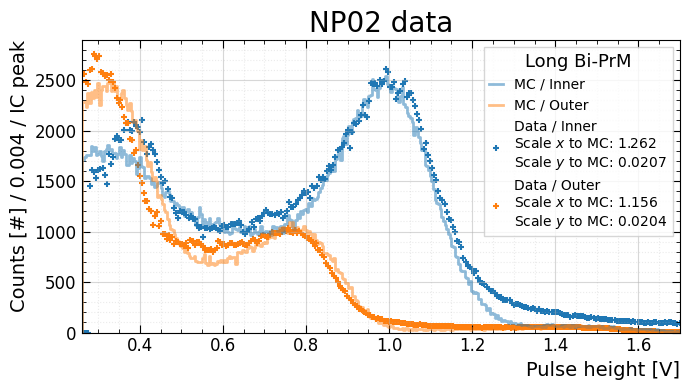

In [6]:
fig, ax = plt.subplots(figsize=(7, 4), ncols=1, layout='tight')
width = 0.004; binning = numpy.arange(0.2, 1.7+width, width)

### simulation

# inner
y, bins = numpy.histogram(LONG_PrM_MC[0].phmax, bins=binning)
x = (bins[:-1] + bins[1:]) / 2
ax.step(
    x, y, where='post', 
    label = f'MC / Inner', c='C0', alpha=0.5, linewidth=2 
)

Mask = (x > 0.9) & (x < 1.3)
pars, covs = scipy.optimize.curve_fit(
    pmana.utils.fitting.Gaus, 
    x[Mask], y[Mask], 
    p0 = (numpy.max(y[Mask]), 1., 0.1), maxfev=1000
)
InnerA_Sim = pars[0]; InnerPos_Sim = pars[1]

# outer
y, bins = numpy.histogram(LONG_PrM_MC[1].phmax, bins=binning)
x = (bins[:-1] + bins[1:]) / 2
ax.step(
    x, y, where='post', 
    label = f'MC / Outer', c='C1', alpha=0.5, linewidth=2 
)

Mask = (x > 0.6) & (x < 1)
pars, covs = scipy.optimize.curve_fit(
    pmana.utils.fitting.Gaus, 
    x[Mask], y[Mask], 
    p0 = (numpy.max(y[Mask]), 0.8, 0.1), maxfev=1000
)
OuterA_Sim = pars[0]; OuterPos_Sim = pars[1]

### data

# inner
x = numpy.array(LONG_PrM[0].index).astype(float)
y = numpy.array(LONG_PrM[0].YLong_Inner)

Mask = (x > 0.65) & (x < 1.)
pars, covs = scipy.optimize.curve_fit(
    pmana.utils.fitting.Gaus, 
    x[Mask], y[Mask], 
    p0 = (numpy.max(y[Mask]), 0.8, 0.1), maxfev=1000
)
InnerA_Data = pars[0]
InnerPos_Data = pars[1]

InnerYScaleToSim = InnerA_Sim / InnerA_Data
InnerScaleToSim = InnerPos_Sim / InnerPos_Data
ax.scatter(
    LONG_PrM[0].index * InnerScaleToSim,
    LONG_PrM[0] * InnerYScaleToSim,
    label = f'Data / Inner\nScale $x$ to MC: {InnerScaleToSim:.3f}\nScale $y$ to MC: {InnerYScaleToSim:.4f}',
    lw=1.5,
    marker='+',
    s=20
)

# outer
x = numpy.array(LONG_PrM[1].index).astype(float)
y = numpy.array(LONG_PrM[1].YLong_Outer)

Mask = (x > 0.65) & (x < 1.)
pars, covs = scipy.optimize.curve_fit(
    pmana.utils.fitting.Gaus, 
    x[Mask], y[Mask], 
    p0 = (numpy.max(y[Mask]), 0.8, 0.1), maxfev=1000
)
OuterA_Data = pars[0]
OuterPos_Data = pars[1]

OuterYScaleToSim = OuterA_Sim / OuterA_Data
OuterScaleToSim = OuterPos_Sim / OuterPos_Data
ax.scatter(
    LONG_PrM[1].index * OuterScaleToSim,
    LONG_PrM[1] * OuterYScaleToSim,
    label = f'Data / Outer\nScale $x$ to MC: {OuterScaleToSim:.3f}\nScale $y$ to MC: {OuterYScaleToSim:.4f}',
    lw=1.5,
    marker='+',
    s=20
)

# gfx
pmana.utils.plotting.UpdateMatplotlibStyle(ax, 'Pulse height [V]', f'Counts [#] / {width} / IC peak')
ax.set_title('NP02 data', fontsize=20)
legend = ax.legend(handlelength=1, fancybox=False, frameon=True, title='Long Bi-PrM')
legend.get_title().set_fontsize('13')
ax.set_ylim(0, ax.get_ylim()[1])
ax.set_xlim(0.26, 1.7)
ax.grid(alpha=0.5)
ax.grid(alpha=0.25, which='minor', ls=':')
plt.show()
fig.savefig('../../plots/sim/LongBiPrM_20ms.png', dpi=300)

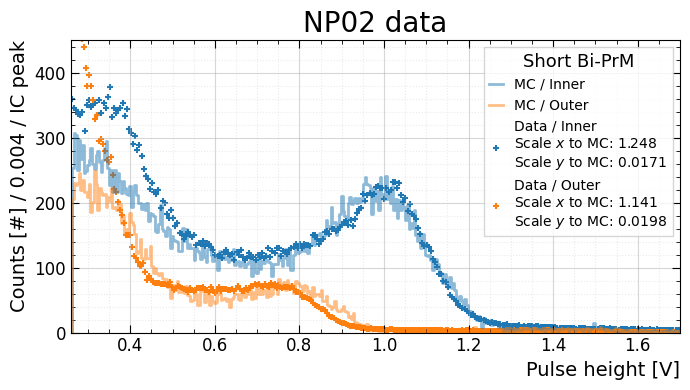

In [7]:
fig, ax = plt.subplots(figsize=(7, 4), ncols=1, layout='tight')
width = 0.004; binning = numpy.arange(0.2, 1.7+width, width)

### simulation

# inner
y, bins = numpy.histogram(SHORT_PrM_MC[0].phmax, bins=binning)
x = (bins[:-1] + bins[1:]) / 2
ax.step(
    x, y, where='post', 
    label = f'MC / Inner', c='C0', alpha=0.5, linewidth=2 
)

Mask = (x > 0.9) & (x < 1.3)
pars, covs = scipy.optimize.curve_fit(
    pmana.utils.fitting.Gaus, 
    x[Mask], y[Mask], 
    p0 = (numpy.max(y[Mask]), 1., 0.1), maxfev=1000
)
InnerA_Sim = pars[0]; InnerPos_Sim = pars[1]

# outer
y, bins = numpy.histogram(SHORT_PrM_MC[1].phmax, bins=binning)
x = (bins[:-1] + bins[1:]) / 2
ax.step(
    x, y, where='post', 
    label = f'MC / Outer', c='C1', alpha=0.5, linewidth=2 
)

Mask = (x > 0.6) & (x < 1)
pars, covs = scipy.optimize.curve_fit(
    pmana.utils.fitting.Gaus, 
    x[Mask], y[Mask], 
    p0 = (numpy.max(y[Mask]), 0.8, 0.1), maxfev=1000
)
OuterA_Sim = pars[0]; OuterPos_Sim = pars[1]

### data

# inner
x = numpy.array(SHORT_PrM[0].index).astype(float)
y = numpy.array(SHORT_PrM[0].YShort_Inner)

Mask = (x > 0.65) & (x < 1.)
pars, covs = scipy.optimize.curve_fit(
    pmana.utils.fitting.Gaus, 
    x[Mask], y[Mask], 
    p0 = (numpy.max(y[Mask]), 0.8, 0.1), maxfev=1000
)
InnerA_Data = pars[0]
InnerPos_Data = pars[1]

InnerYScaleToSim = InnerA_Sim / InnerA_Data
InnerScaleToSim = InnerPos_Sim / InnerPos_Data
ax.scatter(
    SHORT_PrM[0].index * InnerScaleToSim,
    SHORT_PrM[0] * InnerYScaleToSim,
    label = f'Data / Inner\nScale $x$ to MC: {InnerScaleToSim:.3f}\nScale $y$ to MC: {InnerYScaleToSim:.4f}',
    lw=1.5,
    marker='+',
    s=20
)

# outer
x = numpy.array(SHORT_PrM[1].index).astype(float)
y = numpy.array(SHORT_PrM[1].YShort_Outer)

Mask = (x > 0.65) & (x < 1.)
pars, covs = scipy.optimize.curve_fit(
    pmana.utils.fitting.Gaus, 
    x[Mask], y[Mask], 
    p0 = (numpy.max(y[Mask]), 0.8, 0.1), maxfev=1000
)
OuterA_Data = pars[0]
OuterPos_Data = pars[1]

OuterYScaleToSim = OuterA_Sim / OuterA_Data
OuterScaleToSim = OuterPos_Sim / OuterPos_Data
ax.scatter(
    SHORT_PrM[1].index * OuterScaleToSim,
    SHORT_PrM[1] * OuterYScaleToSim,
    label = f'Data / Outer\nScale $x$ to MC: {OuterScaleToSim:.3f}\nScale $y$ to MC: {OuterYScaleToSim:.4f}',
    lw=1.5,
    marker='+',
    s=20
)

# gfx
pmana.utils.plotting.UpdateMatplotlibStyle(ax, 'Pulse height [V]', f'Counts [#] / {width} / IC peak')
ax.set_title('NP02 data', fontsize=20)
legend = ax.legend(handlelength=1, fancybox=False, frameon=True, title='Short Bi-PrM')
legend.get_title().set_fontsize('13')
ax.set_ylim(0, 450)
ax.set_xlim(0.26, 1.7)
ax.grid(alpha=0.5)
ax.grid(alpha=0.25, which='minor', ls=':')
plt.show()
fig.savefig('../../plots/sim/ShortBiPrM_20ms.png', dpi=300)